## Relationship between family dynamics (Marital Status and kidhome) against Types of Products Purchased

In [178]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.cluster import KMeans

In [179]:
def removeOut(dataframe):
    altered = pd.DataFrame() 
    for var in dataframe: 
        Q1 = dataframe[var].quantile(0.25) 
        Q3 = dataframe[var].quantile(0.75) 
        IQR = Q3 - Q1 
        altered[var] = dataframe[var][((dataframe[var] > (Q1 - 1.5 * IQR)) & (dataframe[var] < (Q3 + 1.5 * IQR)))] 
        altered = altered.dropna()
    return altered

In [180]:
#import cleaned data set 
customerdf = pd.read_csv("https://raw.githubusercontent.com/dcjh/1015_Mini_Project/main/Datasets/cleaned_customer.csv") 
customerdf.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,...,10,4,7,0,0,0,0,0,0,1
1,1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,...,1,2,5,0,0,0,0,0,0,0
2,2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,...,2,10,4,0,0,0,0,0,0,0
3,3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,...,0,4,6,0,0,0,0,0,0,0
4,4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,...,3,6,5,0,0,0,0,0,0,0


In [181]:
customerdf.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')


In merging all data sets, we now have 28 columns of data, many of which can be used as predictor variables for our study. In this portion, we will be using Marital Status, Kidhome, and Teenhome to predict the types of product bought.

The predictor variables of choice in this portion will be:

1. **Marital_Status:** Customer's marital status

2. **Kidhome:** Number of children in customer's household

3. **Teenhome:** Number of teenagers in customer's household

Our belief is that the marital status and family composition of customers may influence their purchasing behavior, particularly in relation to the types of products bought. For instance, we believe that: 
-  Married individuals may prioritize wine purchases for social or special occasions.
- Single individuals might spend less on wine compared to married counterparts.

- Families with children and teenagers allocate budget towards fruits, meat, and fish to meet family dietary needs and preferences.
- Besides that, Teenagers may influence higher spending on sweets or snacks within households.

Overall, marital status and family composition can influence spending patterns on various product categories, reflecting differences in household priorities, preferences, and lifestyle choices. Analyzing these relationships can provide valuable insights into consumer behavior and help businesses tailor their marketing strategies and product offerings to different demographic segments

## Extracting Variables
##### We will start by analyzing the variables from the dataset (Marital Status, Kidhome, and Teenhome).


In [182]:
customerdf_joint = customerdf.loc[:, ['Marital_Status', 'Kidhome', 'Teenhome','MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','Dt_Customer', 'Recency']]
customerdf_joint

,Marital_Status,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Dt_Customer,Recency
0,Single,0,0,635,88,546,172,88,88,04-09-2012,58
1,Single,1,1,11,1,6,2,1,6,08-03-2014,38
2,Together,0,0,426,49,127,111,21,42,21-08-2013,26
3,Together,1,0,11,4,20,10,3,5,10-02-2014,26
4,Married,1,0,173,43,118,46,27,15,19-01-2014,94
...,...,...,...,...,...,...,...,...,...,...,...
2211,Married,0,1,709,43,182,42,118,247,13-06-2013,46
2212,Together,2,1,406,0,30,0,0,8,10-06-2014,56
2213,Divorced,0,0,908,48,217,32,12,24,25-01-2014,91
2214,Together,0,1,428,30,214,80,30,61,24-01-2014,8


In [183]:
customerdf_joint['Dt_Customer'] = pd.to_datetime(customerdf_joint['Dt_Customer'], format='%d-%m-%Y')
customerdf_joint['CurrentDate'] = datetime.datetime(2021, 1, 1)
customerdf_joint['numMonths'] = ((customerdf_joint['CurrentDate'] - customerdf_joint['Dt_Customer'])/np.timedelta64(1, 'M'))
customerdf_joint['Recency'] = customerdf_joint['Recency']/30 #assume 30days in a month

In [184]:
#average purchases over the months
for var in customerdf_joint.columns[3:9]:
    customerdf_joint[var] = customerdf_joint[var]/ customerdf_joint["numMonths"]

customerdf_joint.drop(columns = ['Dt_Customer', 'CurrentDate', "numMonths", "Recency"], inplace = True)

In [185]:
customerdf_joint

,Marital_Status,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,Single,0,0,6.473200,0.897073,5.565932,1.753371,0.897073,0.897073
1,Single,1,1,0.136893,0.012445,0.074669,0.024890,0.012445,0.074669
2,Together,0,0,4.909294,0.564684,1.463569,1.279182,0.242007,0.484015
3,Together,1,0,0.135479,0.049265,0.246325,0.123162,0.036949,0.061581
4,Married,1,0,2.112249,0.525010,1.440725,0.561638,0.329657,0.183143
...,...,...,...,...,...,...,...,...,...
2211,Married,0,1,7.966292,0.483146,2.044944,0.471910,1.325843,2.775281
2212,Together,2,1,5.250730,0.000000,0.387985,0.000000,0.000000,0.103463
2213,Divorced,0,0,11.112515,0.587446,2.655744,0.391630,0.146861,0.293723
2214,Together,0,1,5.235991,0.367009,2.617995,0.978690,0.367009,0.746251


In [209]:
customerdf_predictor = pd.DataFrame(customerdf_joint[['Marital_Status', 'Kidhome', 'Teenhome']])
customerdf_predictor


,Marital_Status,Kidhome,Teenhome
0,Single,0,0
1,Single,1,1
2,Together,0,0
3,Together,1,0
4,Married,1,0
...,...,...,...
2211,Married,0,1
2212,Together,2,1
2213,Divorced,0,0
2214,Together,0,1


In [187]:
# convert the categorical variables to numerical values
customerdf_numeric_predictor = pd.DataFrame(customerdf_predictor)

# Encode Marital Status to Numerical Values
label_encoder = LabelEncoder()
customerdf_numeric_predictor['MaritalStatusEncoded'] = label_encoder.fit_transform(customerdf_numeric_predictor['Marital_Status'])

# Drop the original categorical Marital Status column
customerdf_numeric_predictor.drop('Marital_Status', axis=1, inplace=True)

# Display
customerdf_numeric_predictor

,Kidhome,Teenhome,MaritalStatusEncoded
0,0,0,4
1,1,1,4
2,0,0,5
3,1,0,5
4,1,0,3
...,...,...,...
2211,0,1,3
2212,2,1,5
2213,0,0,2
2214,0,1,5


In [214]:
encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Display the mapping
print("Encoding Mapping for Marital Status:")
for label, encoding in encoding_mapping.items():
    print(f"{label}: {encoding}")

Encoding Mapping for Marital Status:
Absurd: 0
Alone: 1
Divorced: 2
Married: 3
Single: 4
Together: 5
Widow: 6
YOLO: 7


In [188]:
customerdf_response = pd.DataFrame(customerdf_joint[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']])
customerdf_response

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,6.473200,0.897073,5.565932,1.753371,0.897073,0.897073
1,0.136893,0.012445,0.074669,0.024890,0.012445,0.074669
2,4.909294,0.564684,1.463569,1.279182,0.242007,0.484015
3,0.135479,0.049265,0.246325,0.123162,0.036949,0.061581
4,2.112249,0.525010,1.440725,0.561638,0.329657,0.183143
...,...,...,...,...,...,...
2211,7.966292,0.483146,2.044944,0.471910,1.325843,2.775281
2212,5.250730,0.000000,0.387985,0.000000,0.000000,0.103463
2213,11.112515,0.587446,2.655744,0.391630,0.146861,0.293723
2214,5.235991,0.367009,2.617995,0.978690,0.367009,0.746251


In [189]:
# convert the categorical variables to numerical values
customerdf_numeric_joint = pd.DataFrame(customerdf_joint)

# Encode Marital Status to Numerical Values
label_encoder = LabelEncoder()
customerdf_numeric_joint['MaritalStatusEncoded'] = label_encoder.fit_transform(customerdf_numeric_joint['Marital_Status'])

# Drop the original categorical Marital Status column
customerdf_numeric_joint.drop('Marital_Status', axis=1, inplace=True)

# Display
customerdf_numeric_joint

,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,MaritalStatusEncoded
0,0,0,6.473200,0.897073,5.565932,1.753371,0.897073,0.897073,4
1,1,1,0.136893,0.012445,0.074669,0.024890,0.012445,0.074669,4
2,0,0,4.909294,0.564684,1.463569,1.279182,0.242007,0.484015,5
3,1,0,0.135479,0.049265,0.246325,0.123162,0.036949,0.061581,5
4,1,0,2.112249,0.525010,1.440725,0.561638,0.329657,0.183143,3
...,...,...,...,...,...,...,...,...,...
2211,0,1,7.966292,0.483146,2.044944,0.471910,1.325843,2.775281,3
2212,2,1,5.250730,0.000000,0.387985,0.000000,0.000000,0.103463,5
2213,0,0,11.112515,0.587446,2.655744,0.391630,0.146861,0.293723,2
2214,0,1,5.235991,0.367009,2.617995,0.978690,0.367009,0.746251,5


In [190]:
customerdf_joint_cleaned = removeOut(customerdf_numeric_joint)
customerdf_response_cleaned = removeOut(customerdf_response)
customerdf_predictor_cleaned = removeOut(customerdf_numeric_predictor)


In [191]:
customerdf_joint_cleaned 

,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,MaritalStatusEncoded
1,1,1,0.136893,0.012445,0.074669,0.024890,0.012445,0.074669,4
2,0,0,4.909294,0.564684,1.463569,1.279182,0.242007,0.484015,5
3,1,0,0.135479,0.049265,0.246325,0.123162,0.036949,0.061581,5
4,1,0,2.112249,0.525010,1.440725,0.561638,0.329657,0.183143,3
5,0,1,6.035193,0.487458,1.137402,0.000000,0.487458,0.162486,5
...,...,...,...,...,...,...,...,...,...
2210,1,0,0.033929,0.033929,0.079168,0.067858,0.022619,0.101788,3
2212,2,1,5.250730,0.000000,0.387985,0.000000,0.000000,0.103463,5
2213,0,0,11.112515,0.587446,2.655744,0.391630,0.146861,0.293723,2
2214,0,1,5.235991,0.367009,2.617995,0.978690,0.367009,0.746251,5


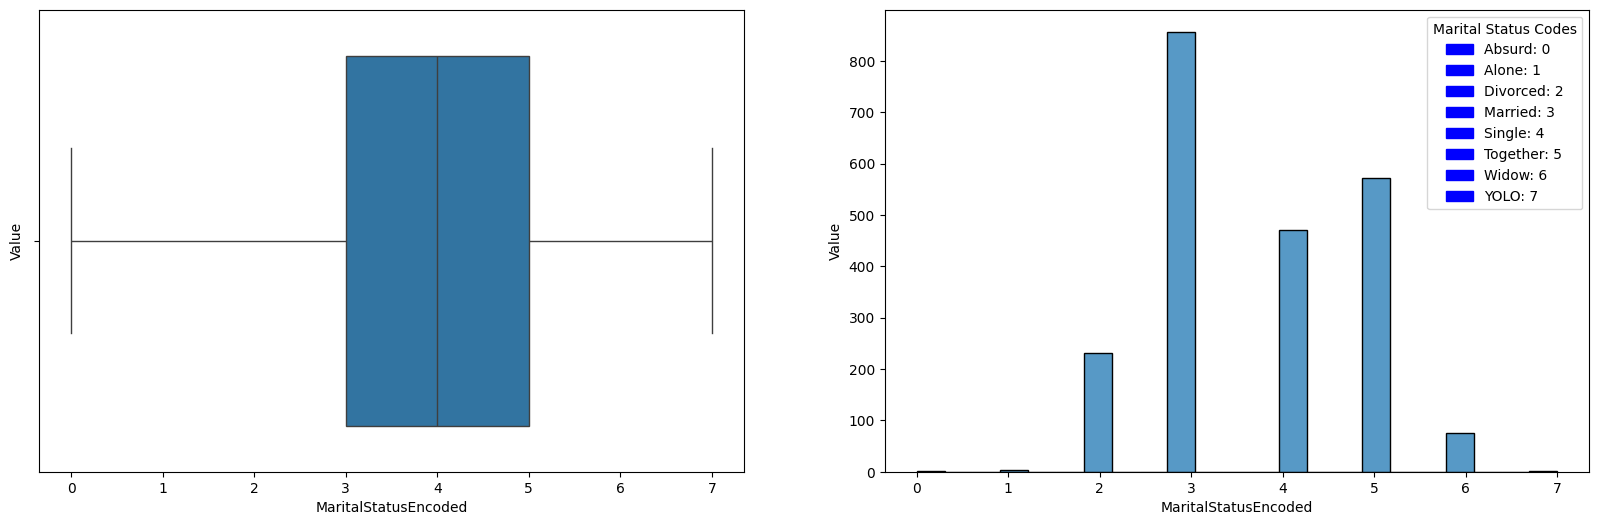

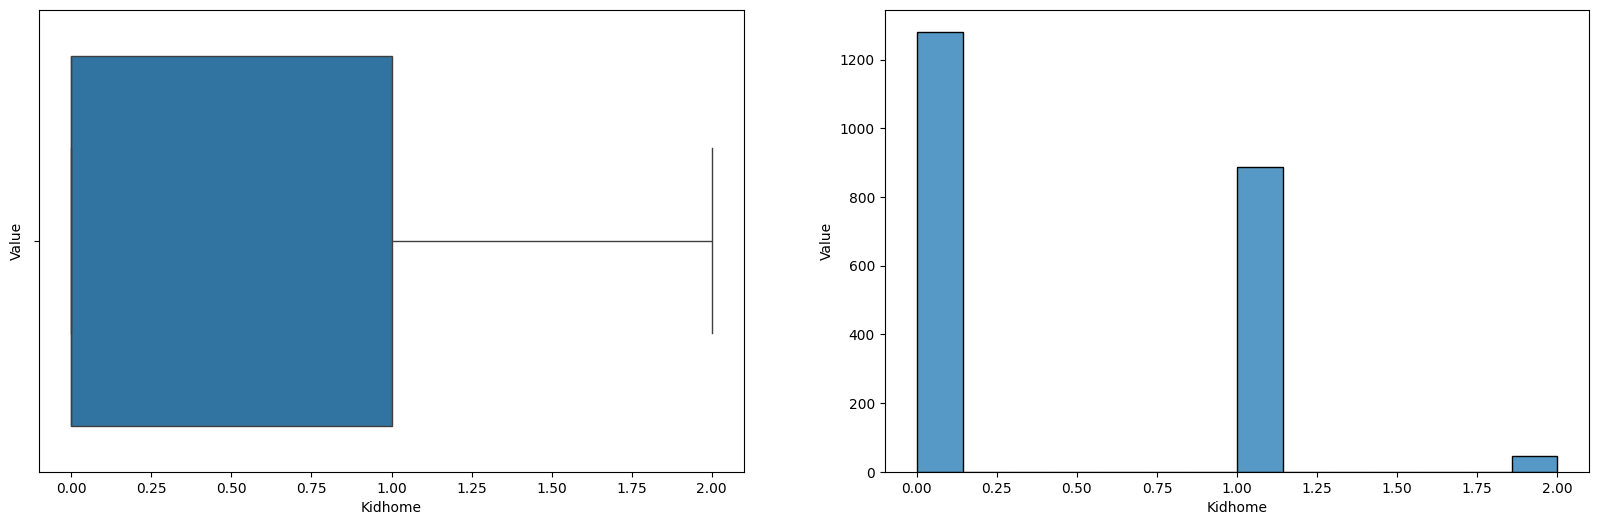

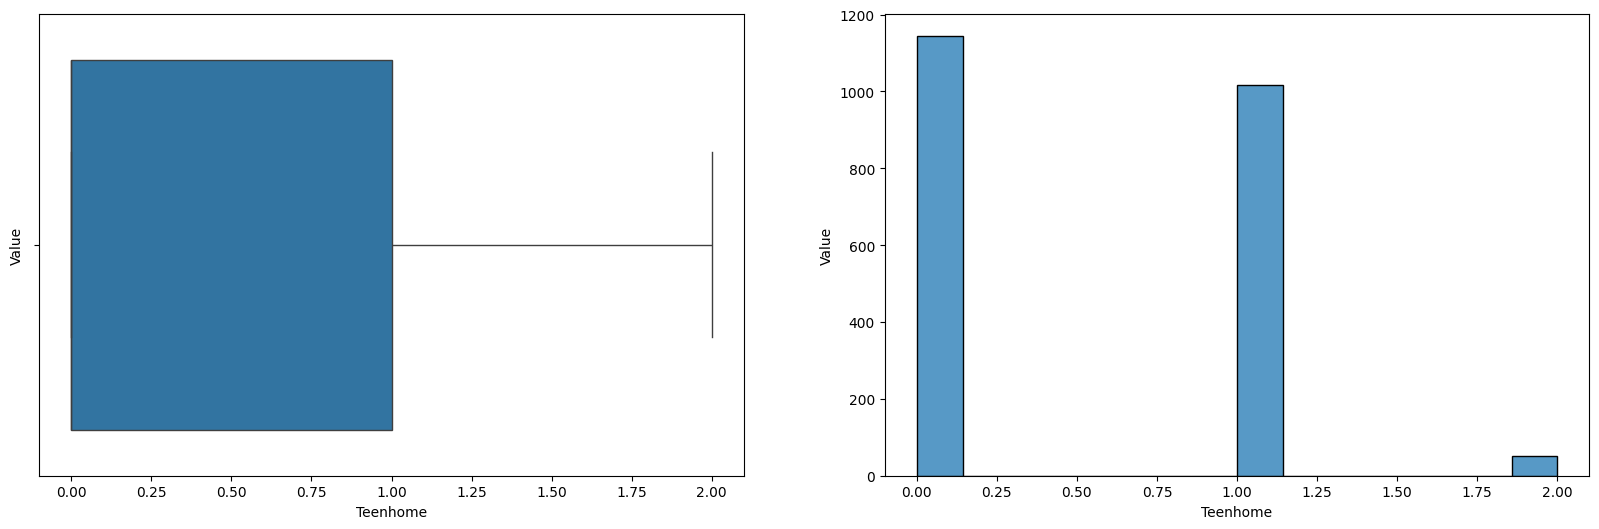

In [240]:
# Martial Status distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_numeric_predictor['MaritalStatusEncoded'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_numeric_predictor['MaritalStatusEncoded'], ax=axes[1])

# Create a list of patch objects with the appropriate color and label for each category

legend_handles = [mpatches.Patch(color='blue', label=f'{label}: {encoding}') for label, encoding in encoding_mapping.items()]
axes[1].legend(handles=legend_handles, title="Marital Status Codes")

for i in range(2):
    axes[i].set_xlabel('MaritalStatusEncoded')
    axes[i].set_ylabel('Value')

plt.show()

# Kidhome distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_predictor_cleaned['Kidhome'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_predictor_cleaned['Kidhome'], ax=axes[1])
for i in range(2):
    axes[i].set_xlabel('Kidhome')
    axes[i].set_ylabel('Value')

# Teenhome distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_predictor_cleaned['Teenhome'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_predictor_cleaned['Teenhome'], ax=axes[1])
for i in range(2):
    axes[i].set_xlabel('Teenhome')
    axes[i].set_ylabel('Value')

plt.show()


As we can observe, the marjority individuals are married with no kids and teens. 

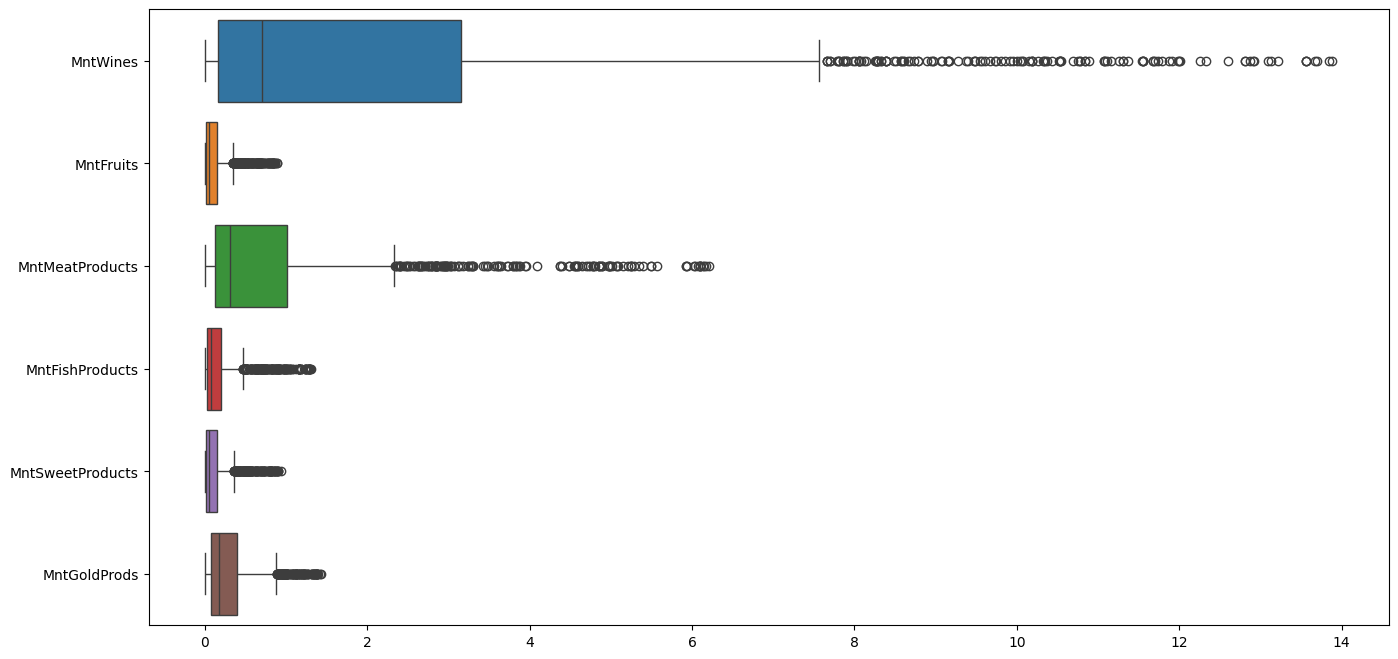

In [193]:
# Draw the Boxplots of response variables
plt.figure(figsize=(16, 8))
sb.boxplot(data=customerdf_response_cleaned, orient="h")
plt.show()


The most product bought by the customer is wine, followed by meat. 

## Jointplot
It will be more interesting to visualize them together in a jointplot as it tells us something about the correlation between the three variables

Encoding Mapping for Marital Status:
Absurd: 0
Alone: 1
Divorced: 2
Married: 3
Single: 4
Together: 5
Widow: 6
YOLO: 7


/var/folders/cz/9z0t9h5148s34k9v2y_x7f9h0000gn/T/ipykernel_19584/447677933.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


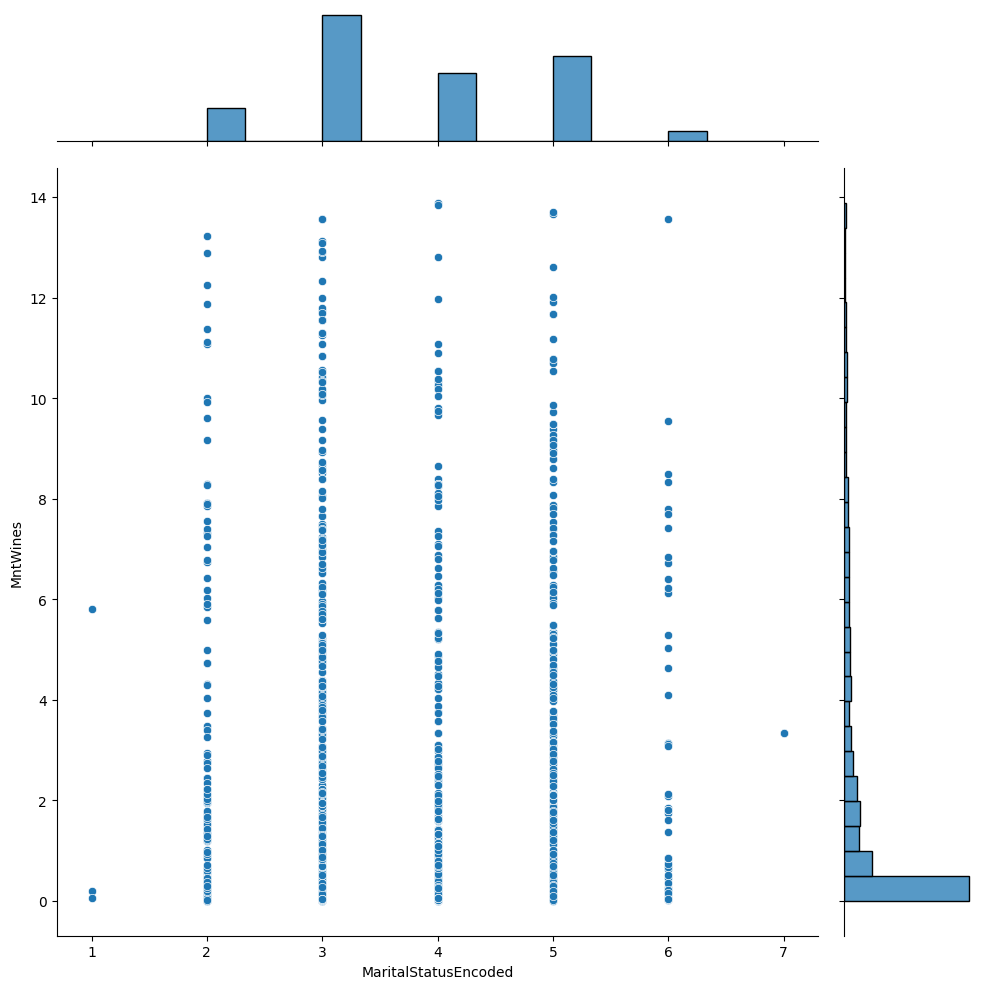

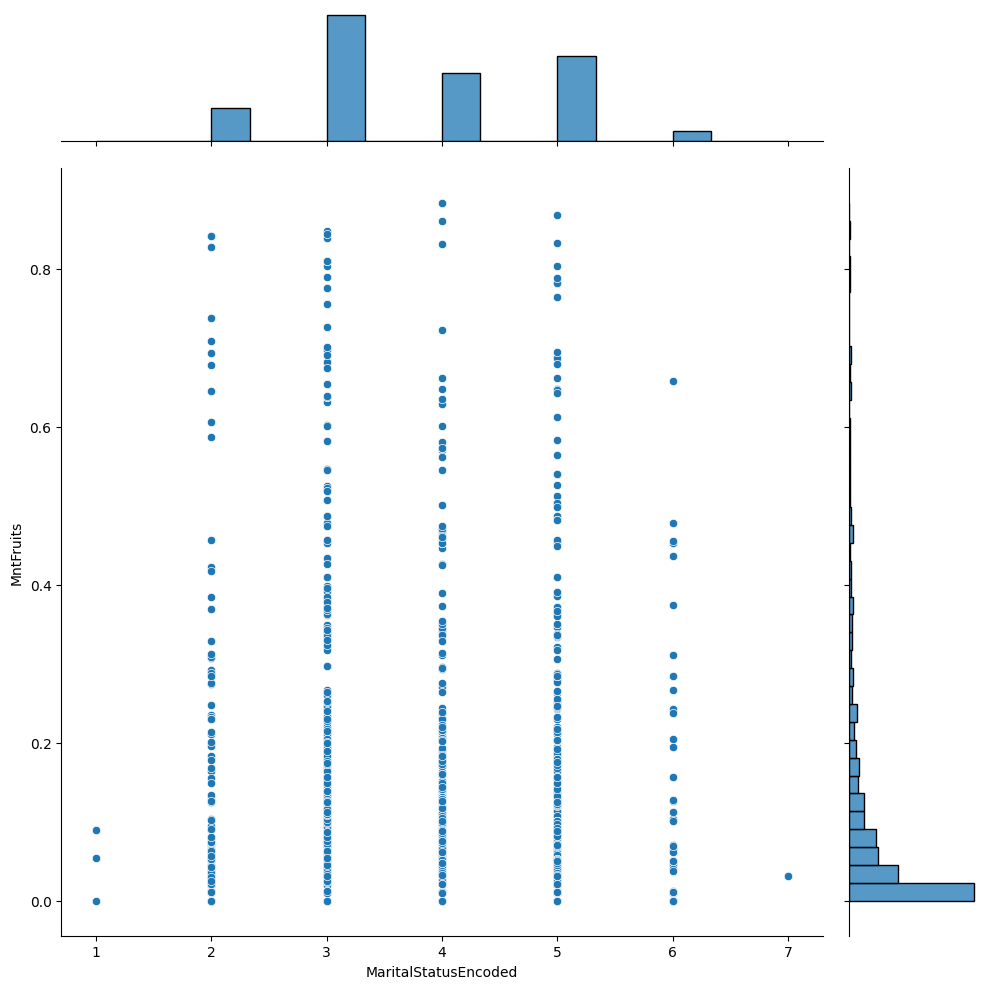

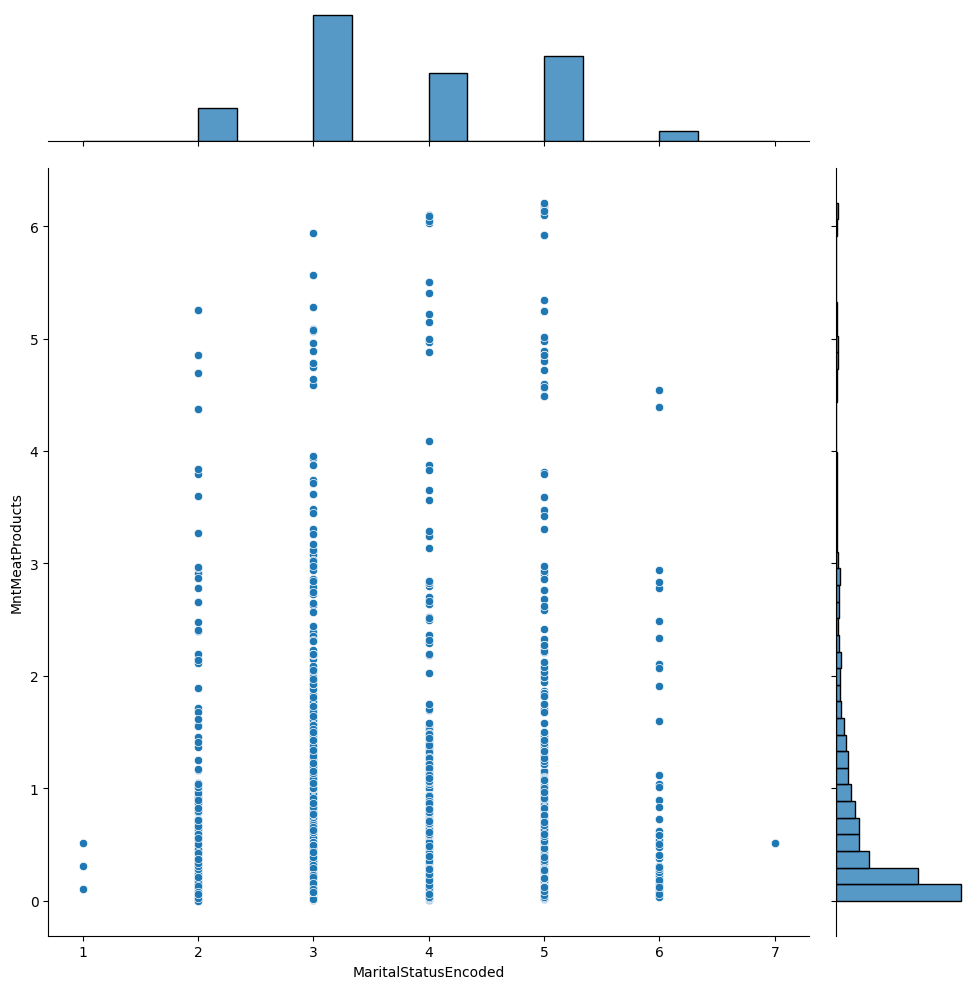

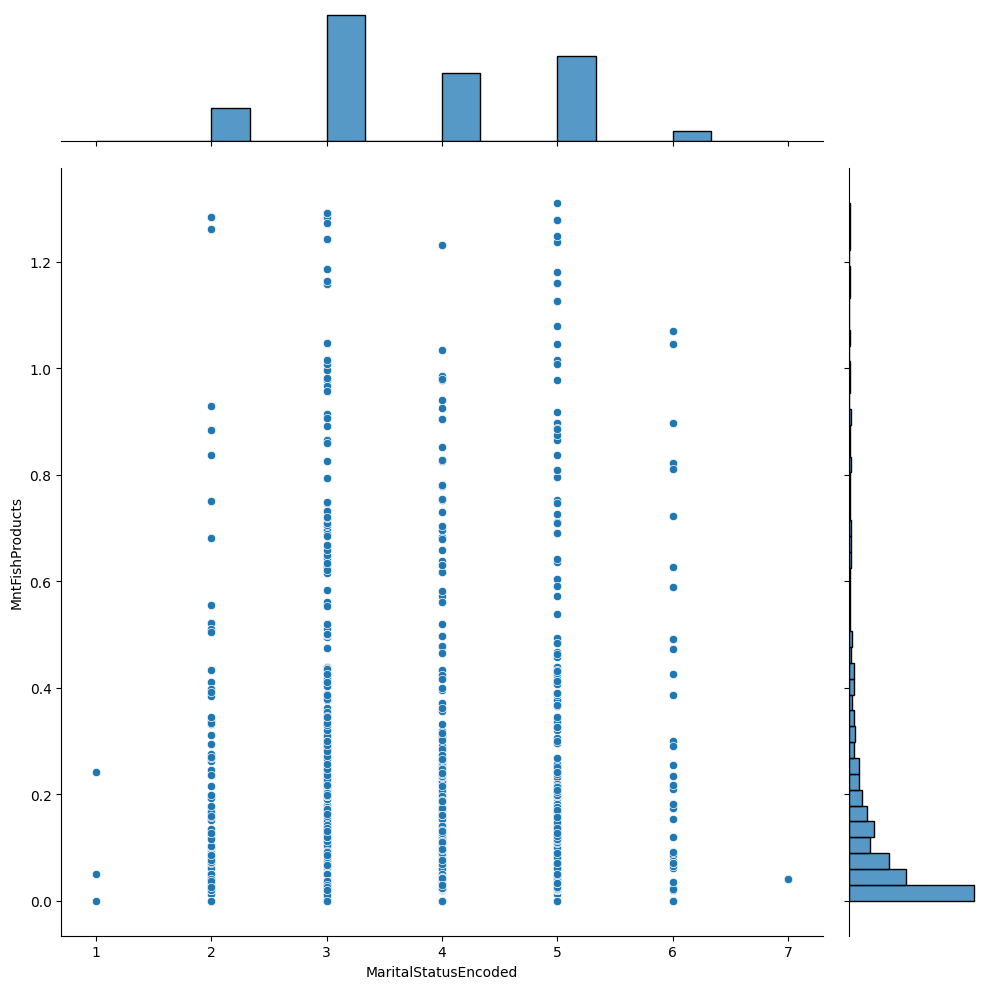

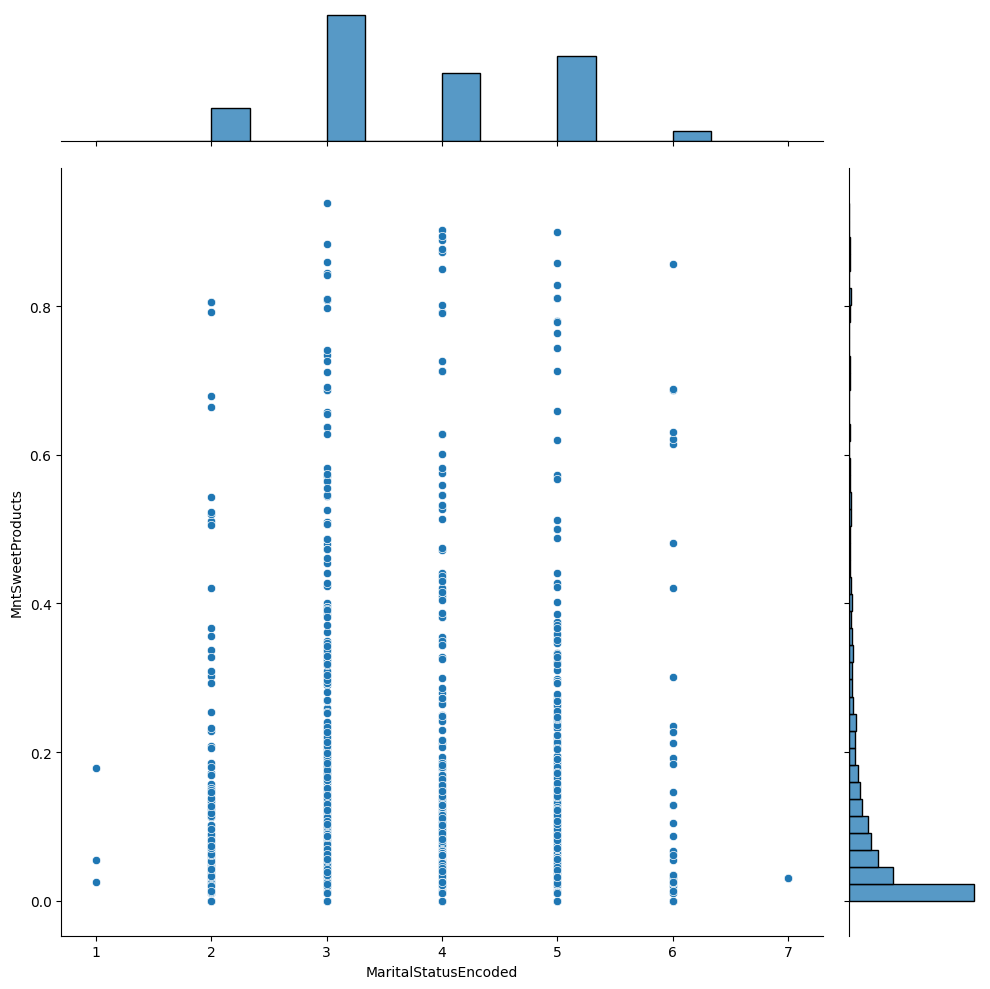

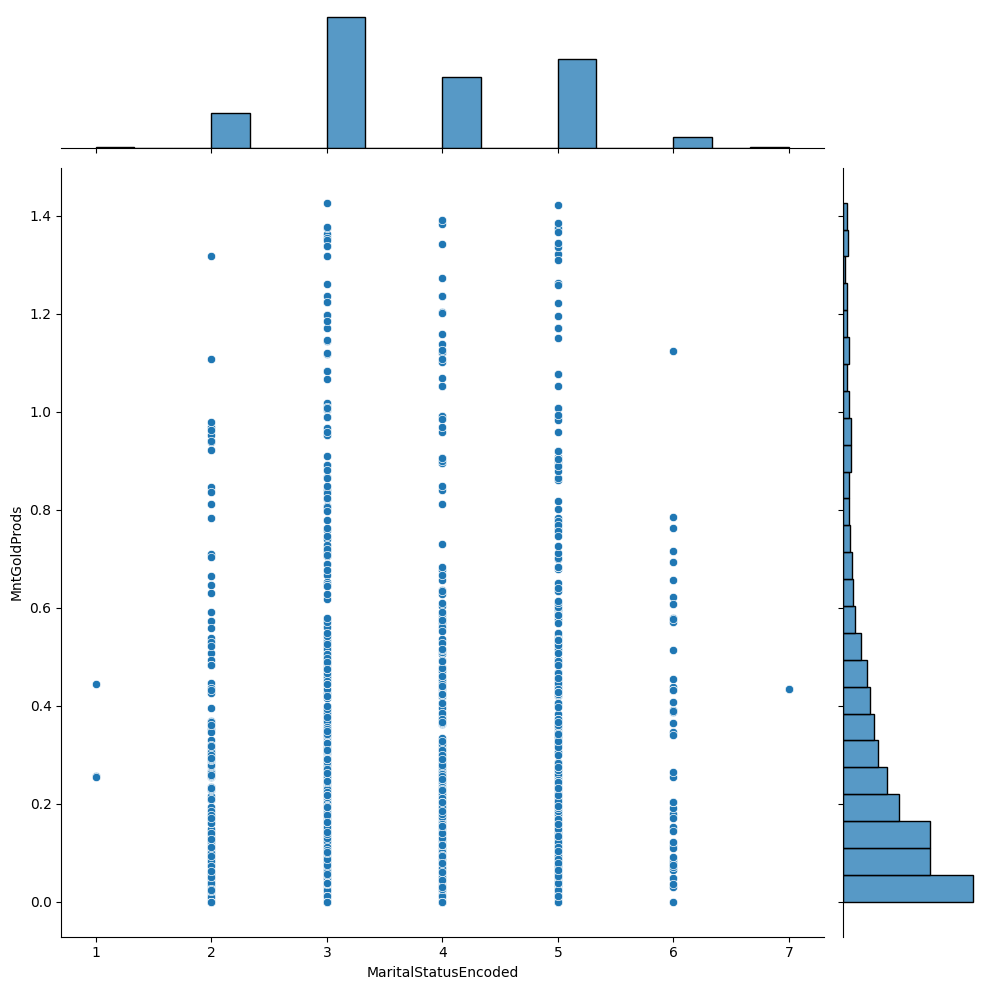

In [241]:
encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Display the mapping
print("Encoding Mapping for Marital Status:")
for label, encoding in encoding_mapping.items():
    print(f"{label}: {encoding}")
    
for var in customerdf_joint_cleaned.columns[2:8]:
    sb.jointplot(data = customerdf_joint_cleaned, y = var, x = "MaritalStatusEncoded", height = 10)

plt.tight_layout()
plt.show()

/var/folders/cz/9z0t9h5148s34k9v2y_x7f9h0000gn/T/ipykernel_19584/3896559298.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


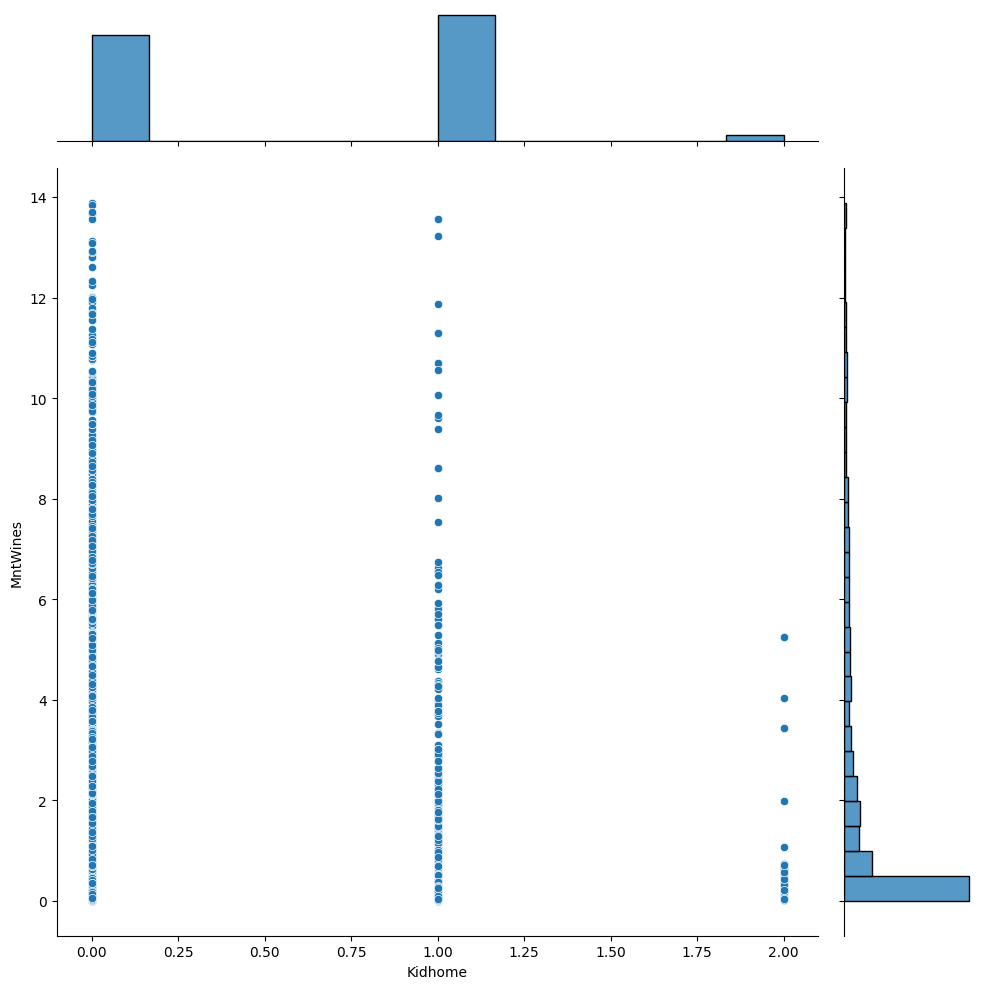

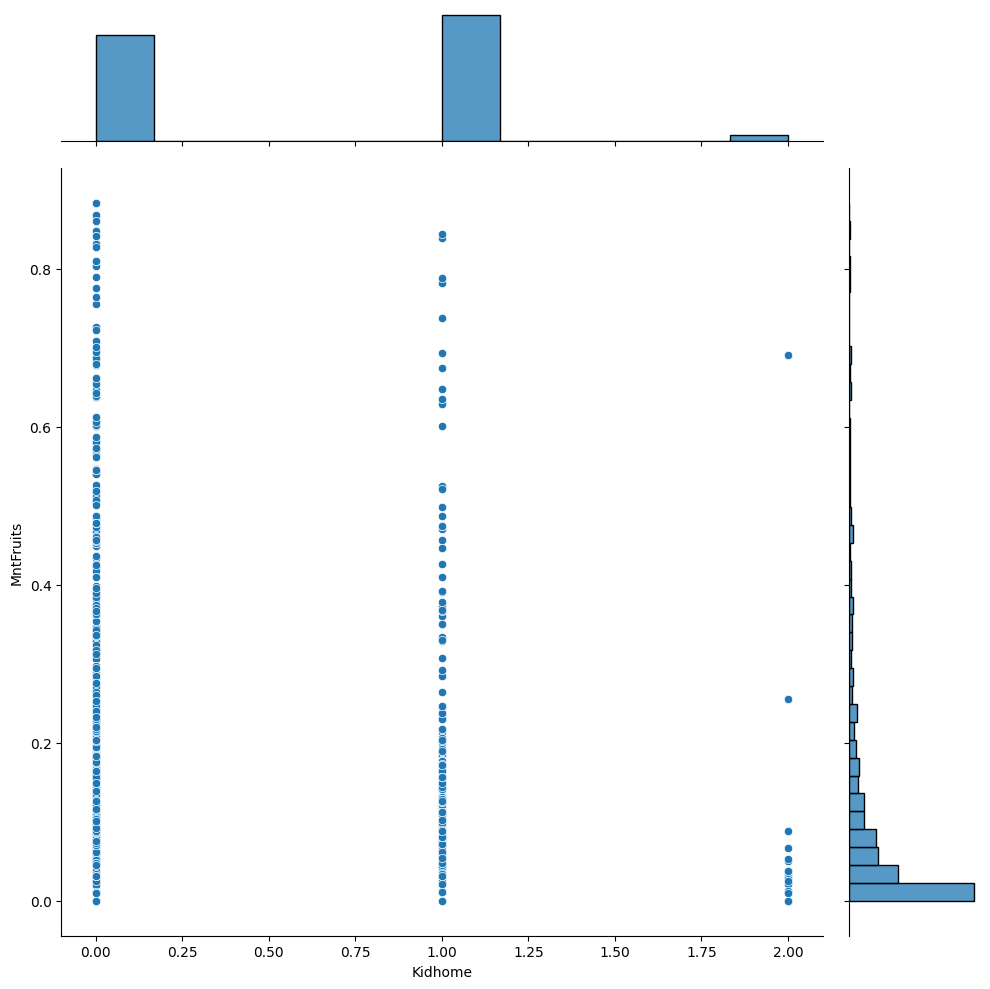

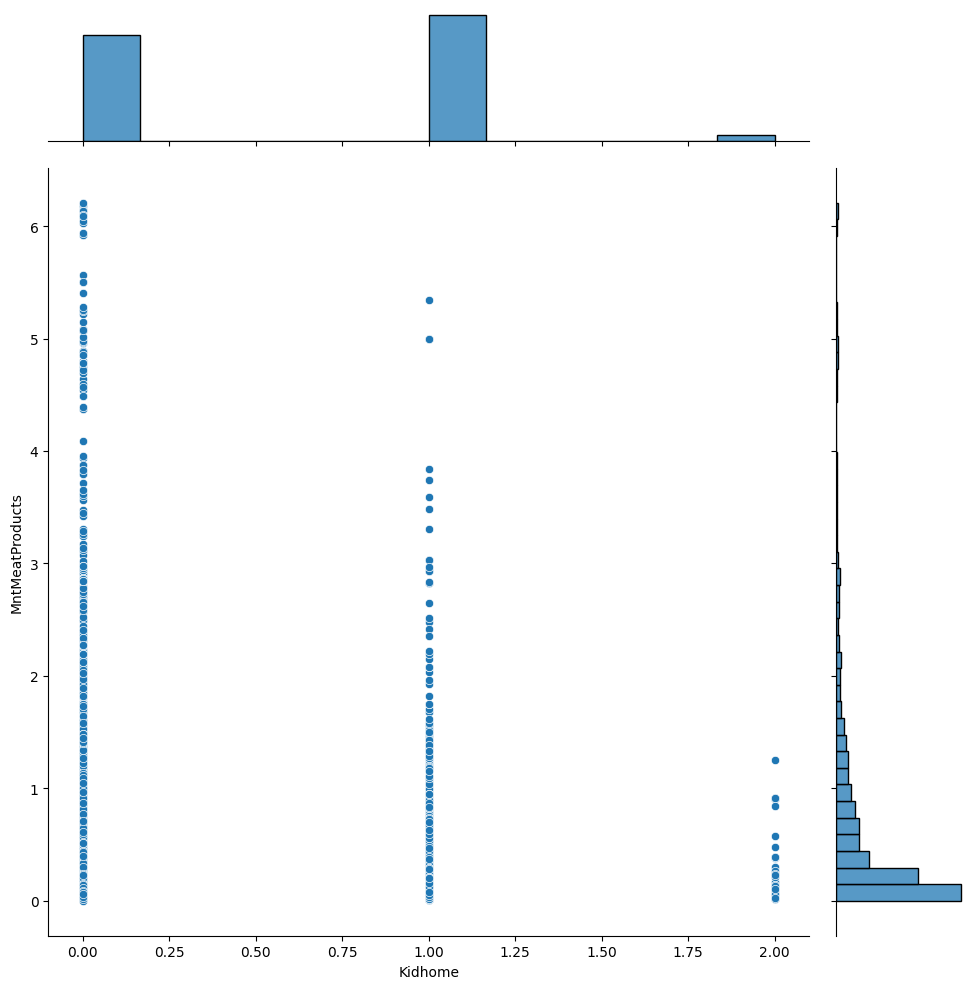

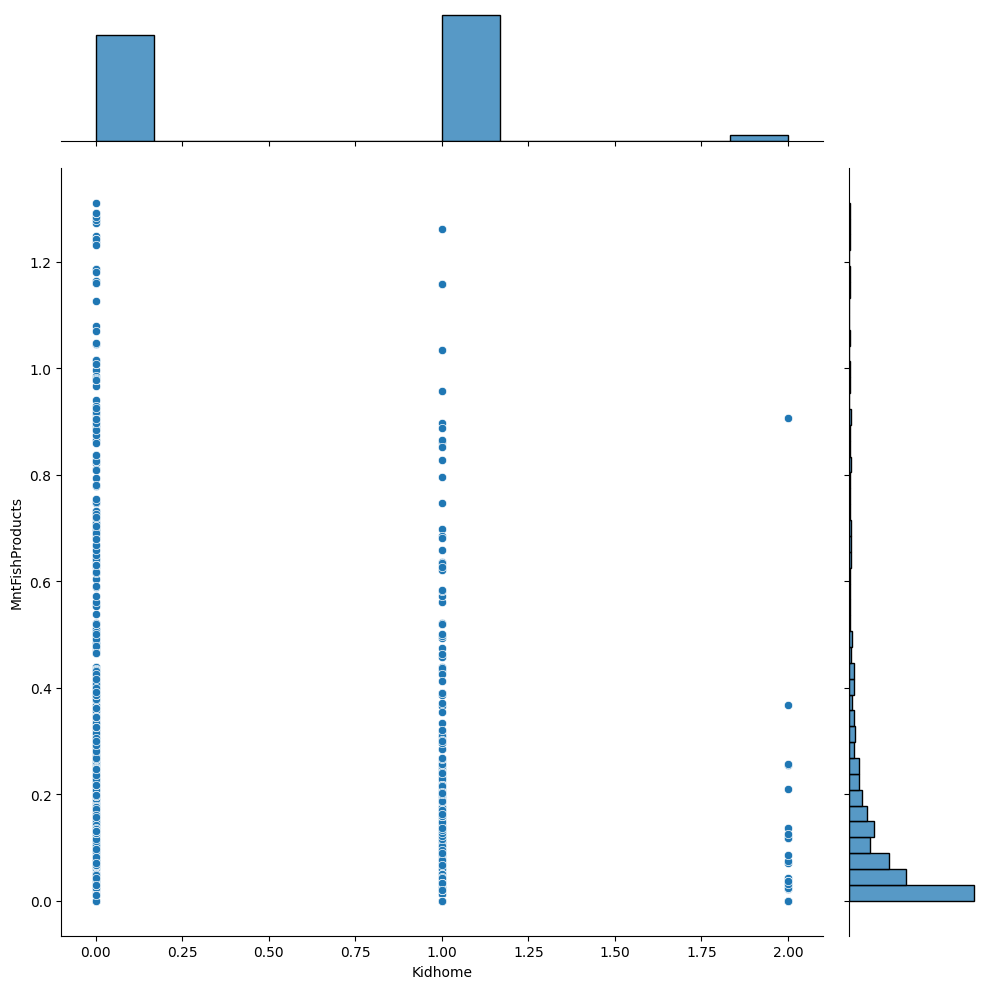

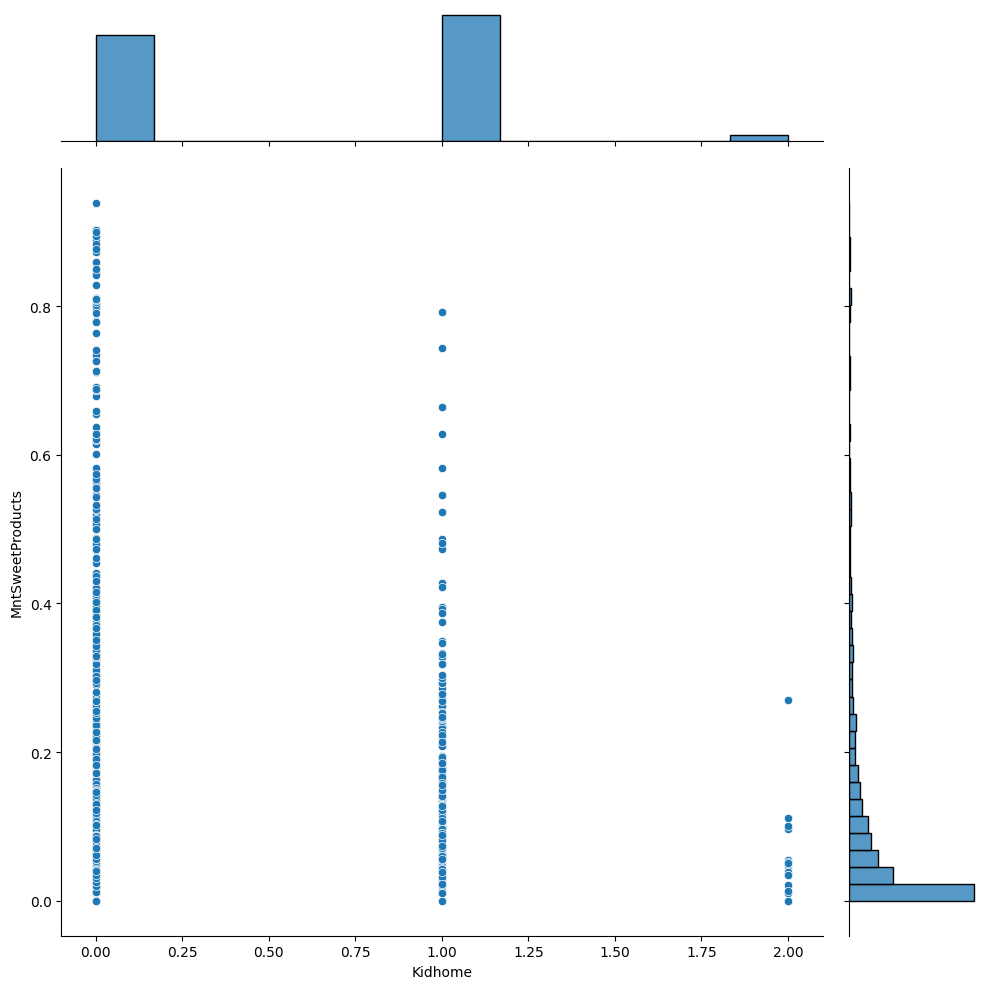

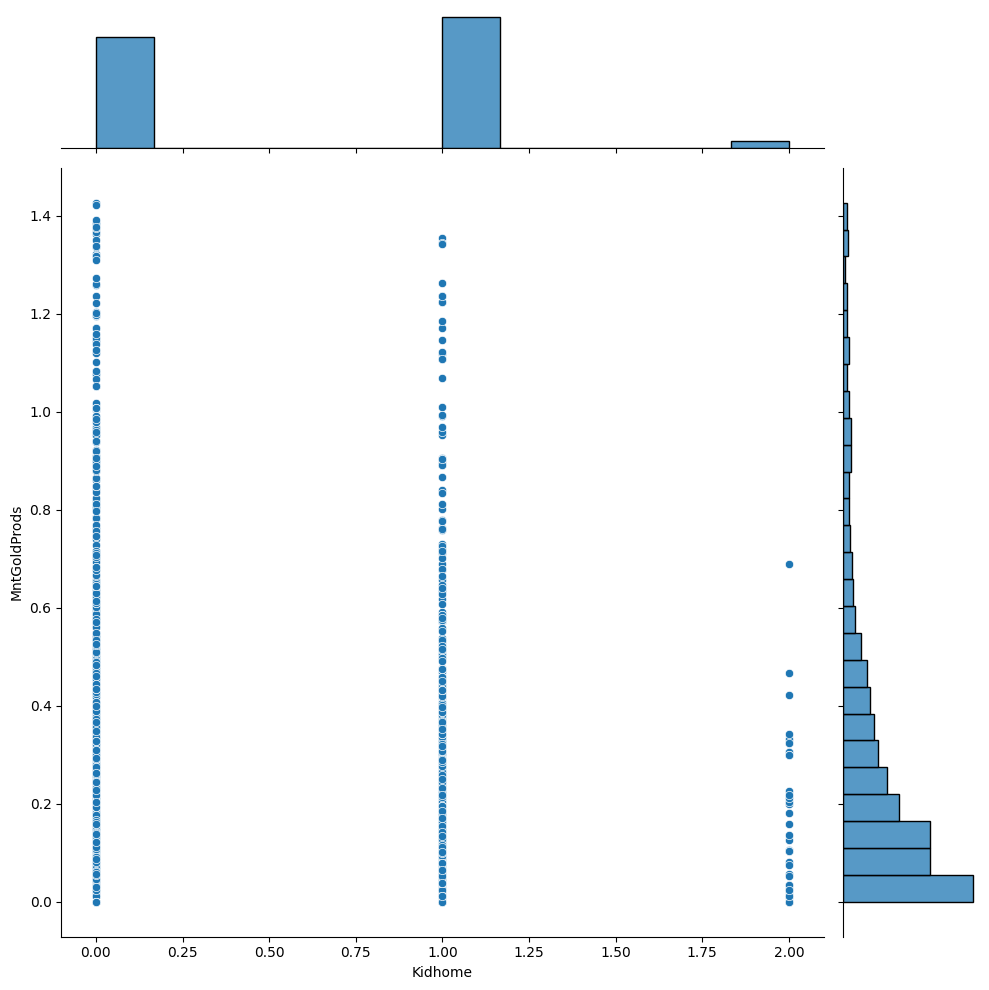

In [195]:
for var in customerdf_joint_cleaned.columns[2:8]:
    sb.jointplot(data = customerdf_joint_cleaned, y = var, x = "Kidhome", height = 10)

plt.tight_layout()
plt.show()

/var/folders/cz/9z0t9h5148s34k9v2y_x7f9h0000gn/T/ipykernel_19584/809313161.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


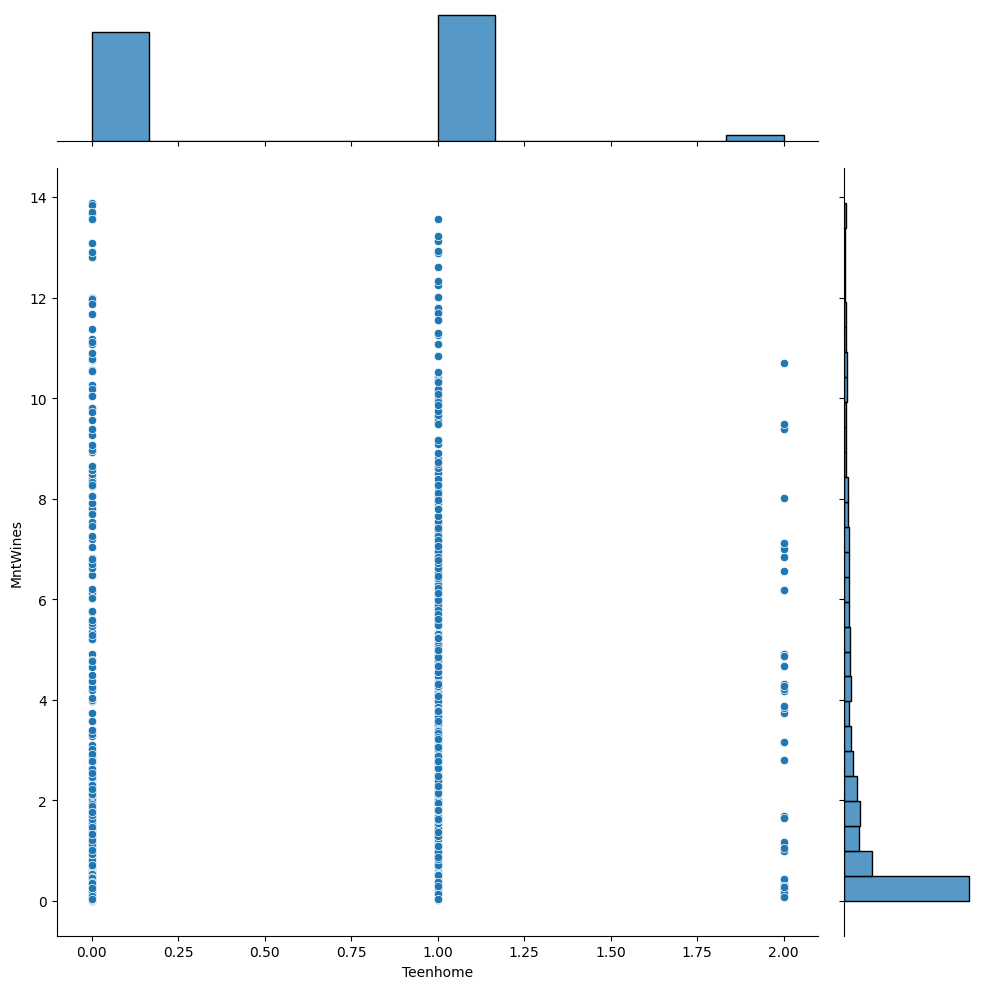

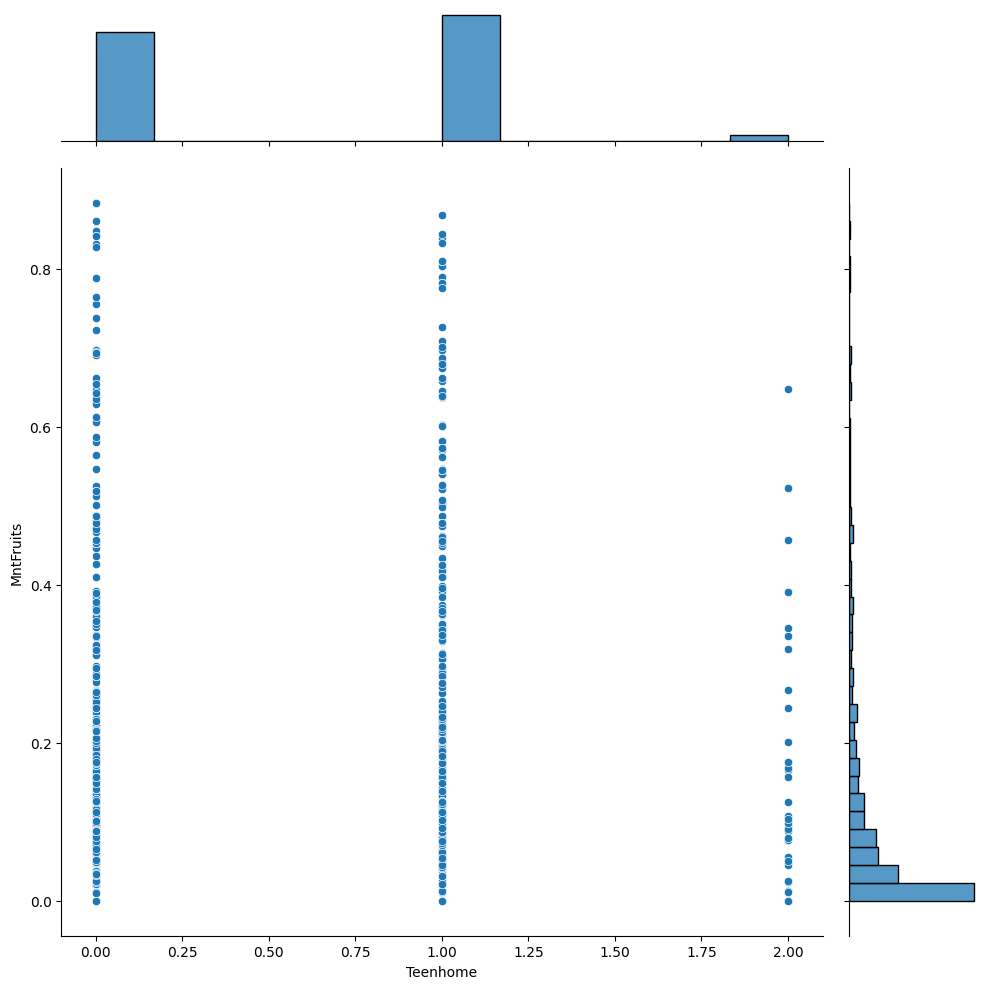

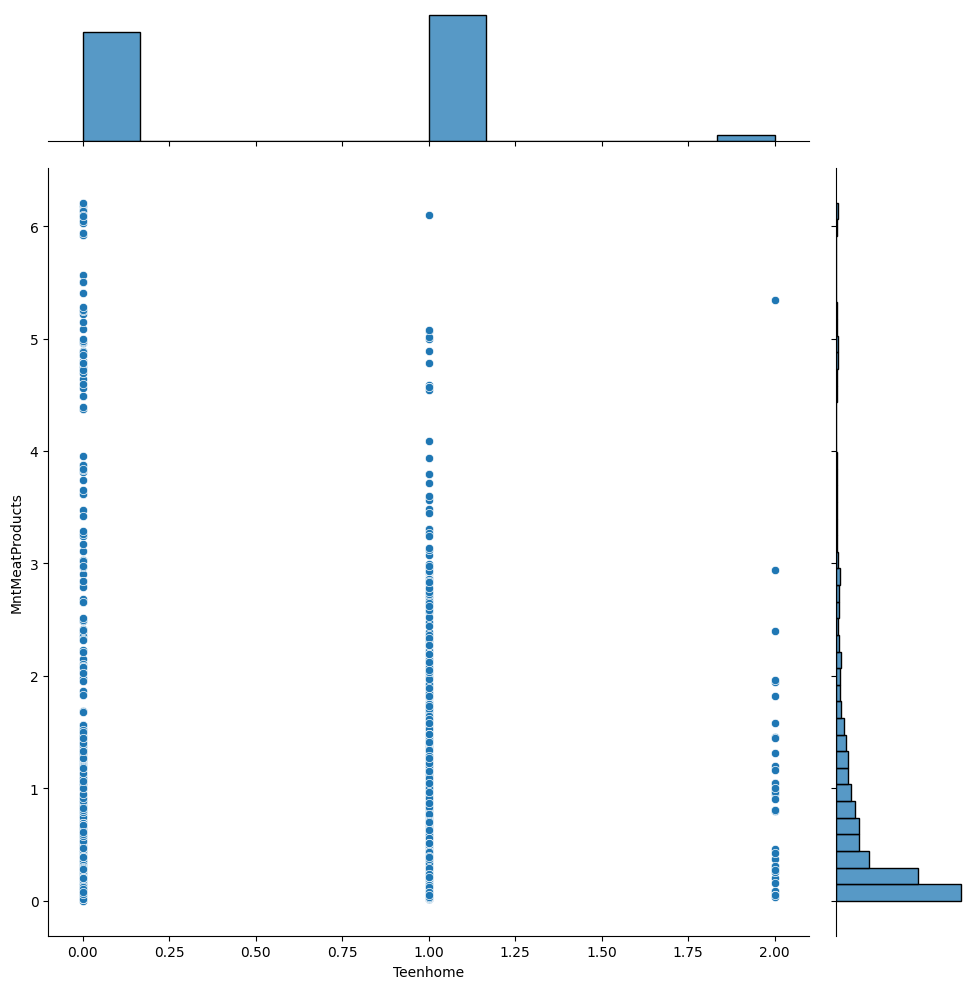

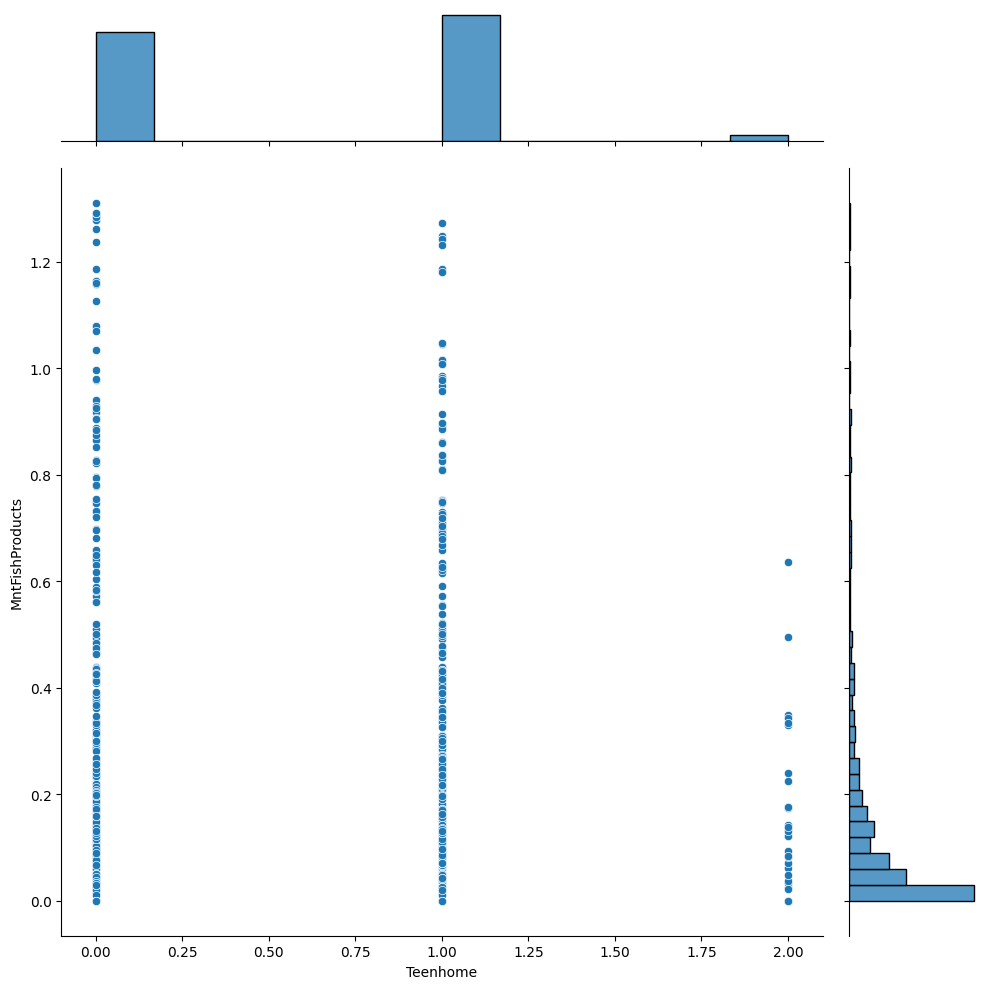

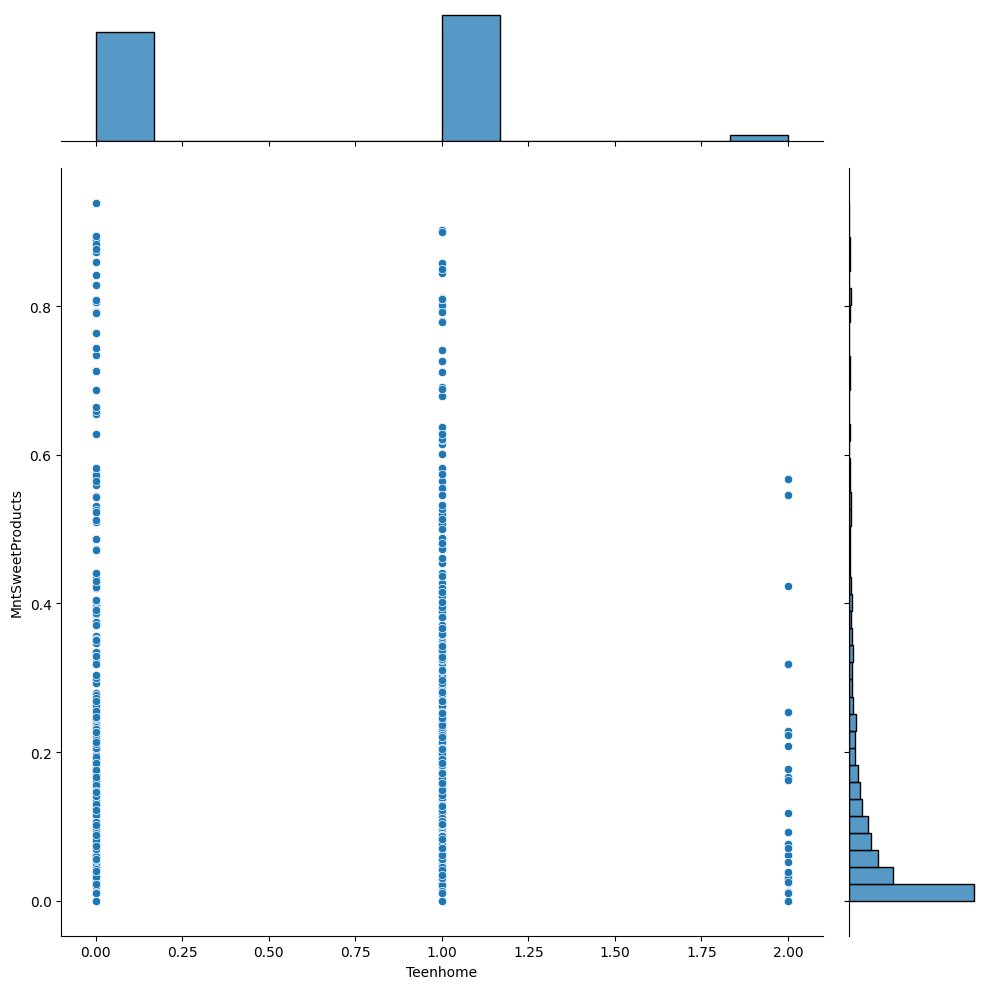

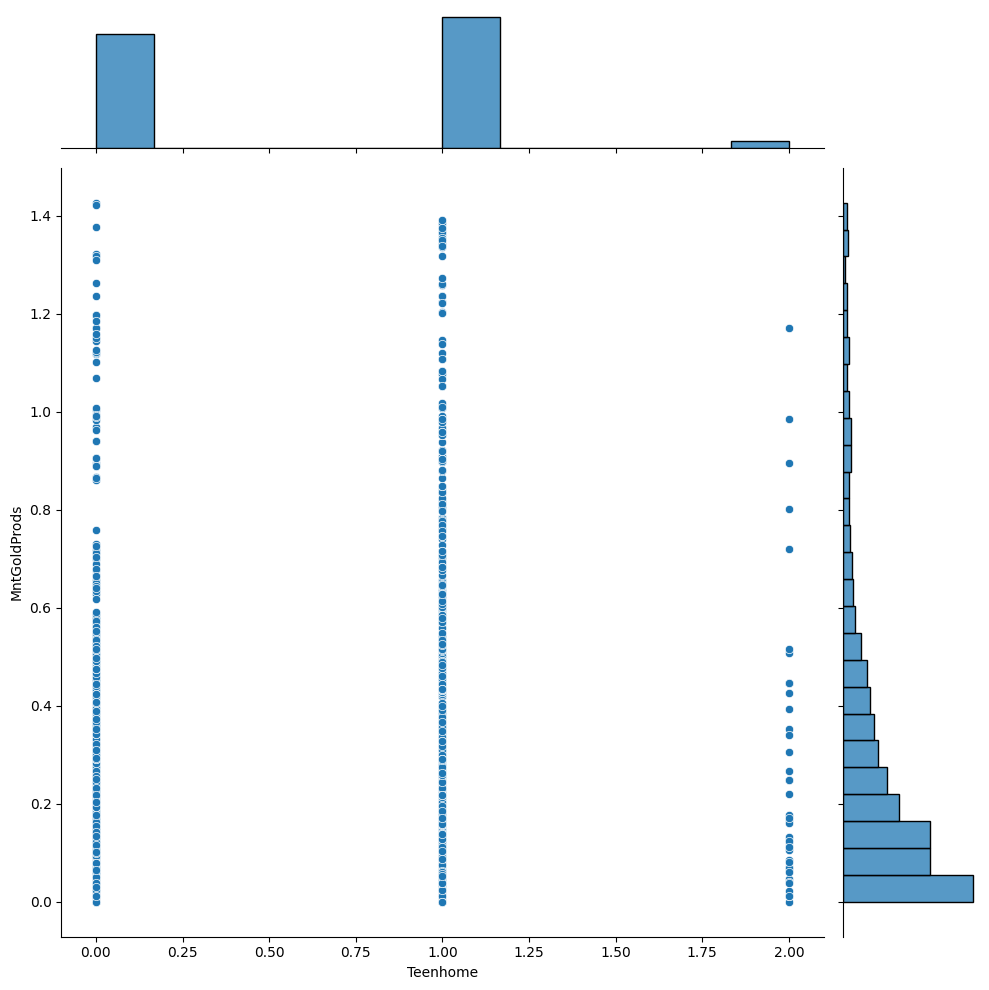

In [196]:
for var in customerdf_joint_cleaned.columns[2:8]:
    sb.jointplot(data = customerdf_joint_cleaned, y = var, x = "Teenhome", height = 10)

plt.tight_layout()
plt.show()

## Correlation matrix 

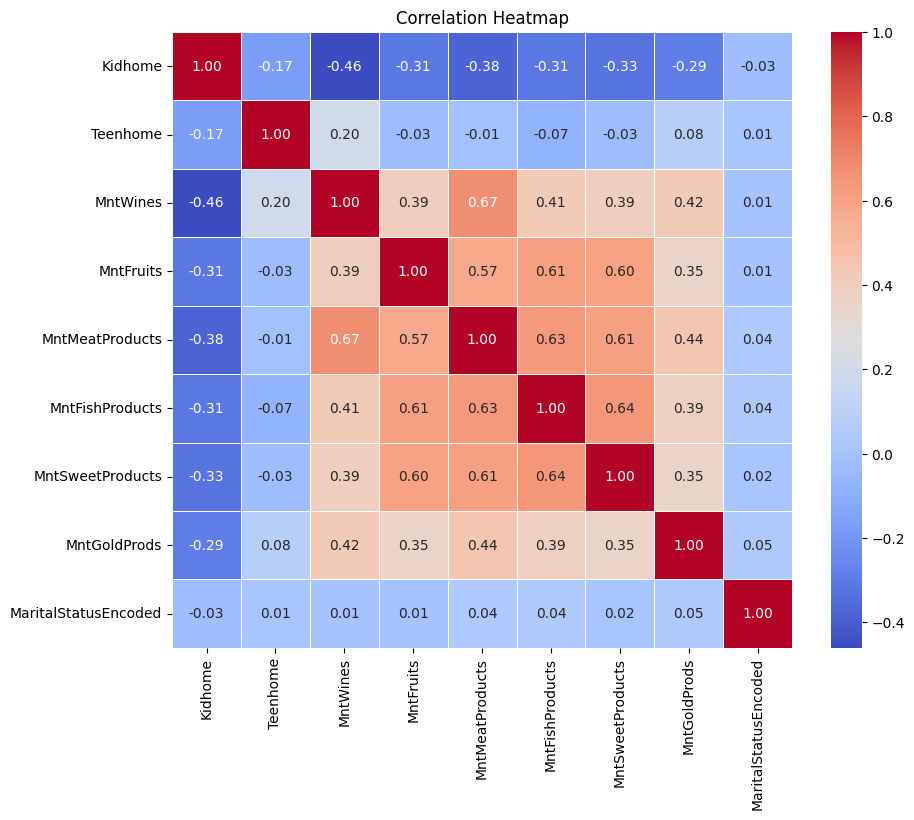

In [197]:
# Assuming customerdf_joint is your DataFrame
df = pd.DataFrame(customerdf_joint_cleaned)

# Encode categorical variables
df['MaritalStatusEncoded'] = df['MaritalStatusEncoded'].astype('category')
df['MaritalStatusEncoded'] = df['MaritalStatusEncoded'].cat.codes

# Compute the correlation matrix
corr_matrix = df.corr()

# create the heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Observation 
There is a fairly good correlation between the number of kids and the amount of wines bought which has a value of -0.50. Thus, as the number of kids at home increases, the amount spent on wines tends to decrease. This shows that having kids play an important factor in purchasing wines. However, the number of teens does not seem to have a correlation. 



# Multi-variate K-means clustering

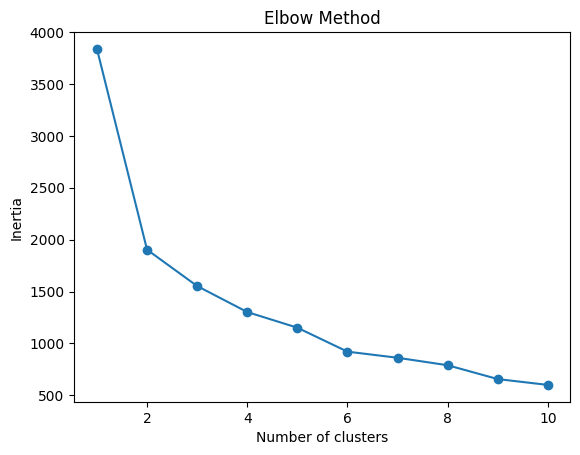

In [198]:
# Calculate inertia for different number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='random', random_state=42)
    kmeans.fit(customerdf_predictor_cleaned)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


optimal number of clusters (k) = 3 using the elbow method 

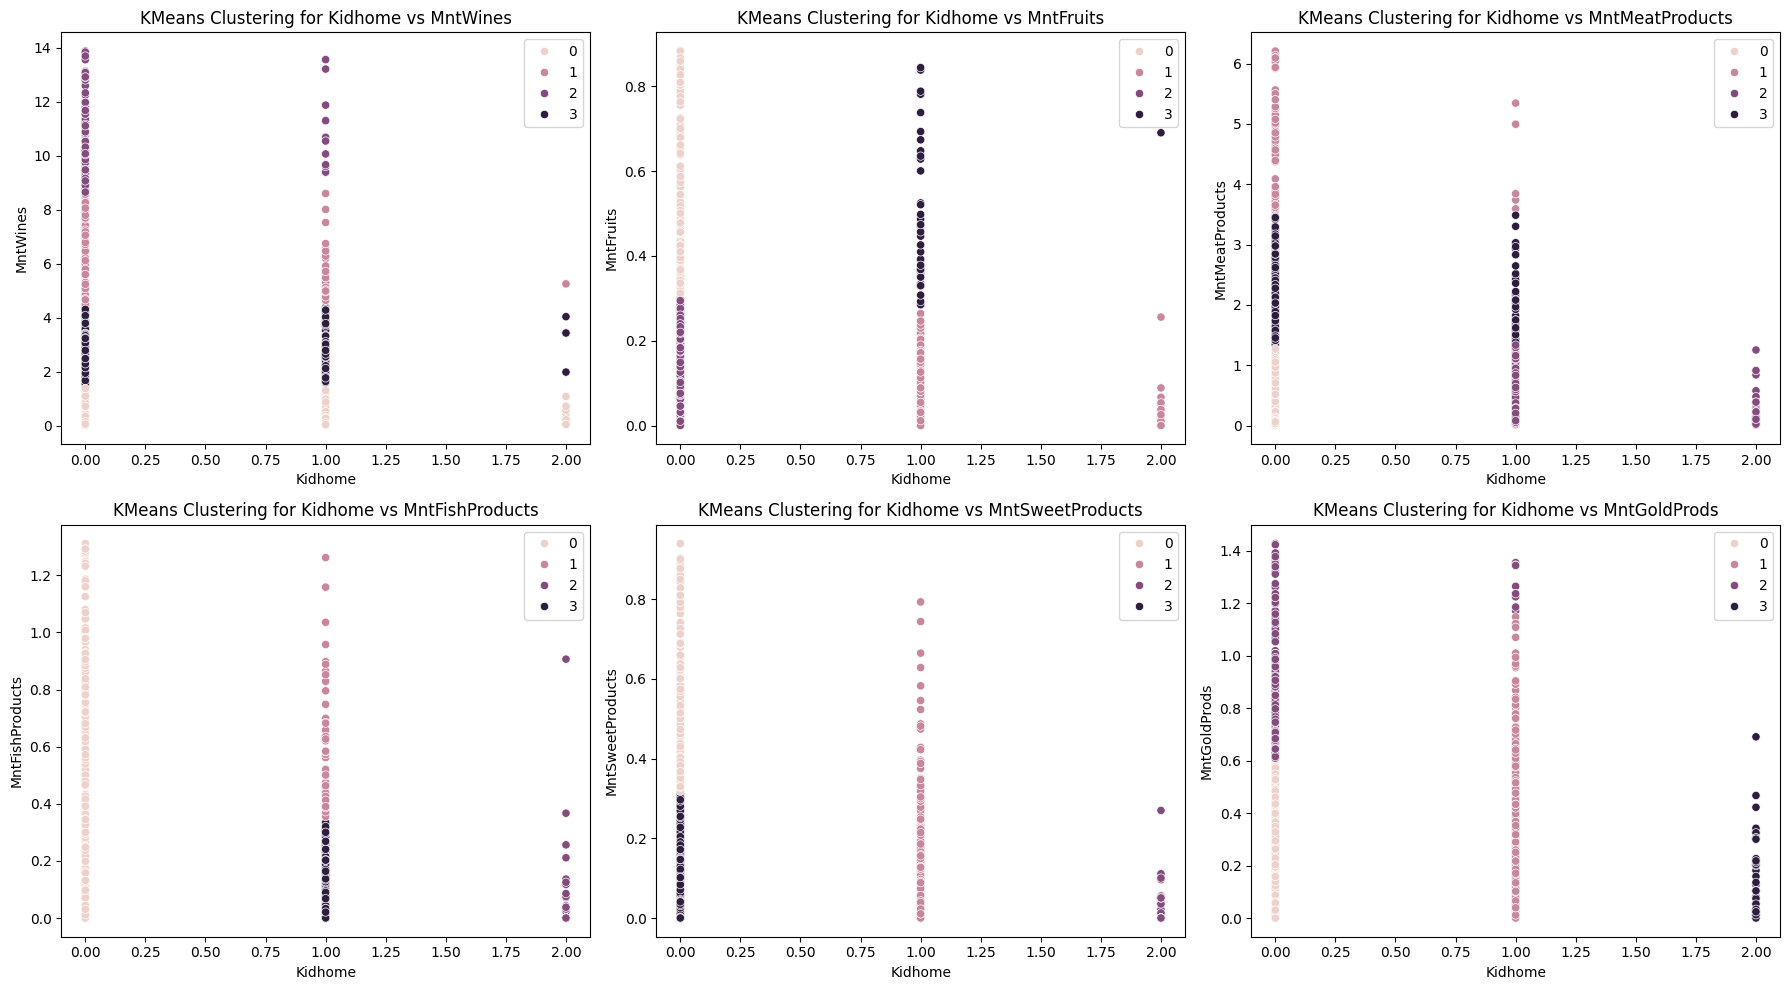

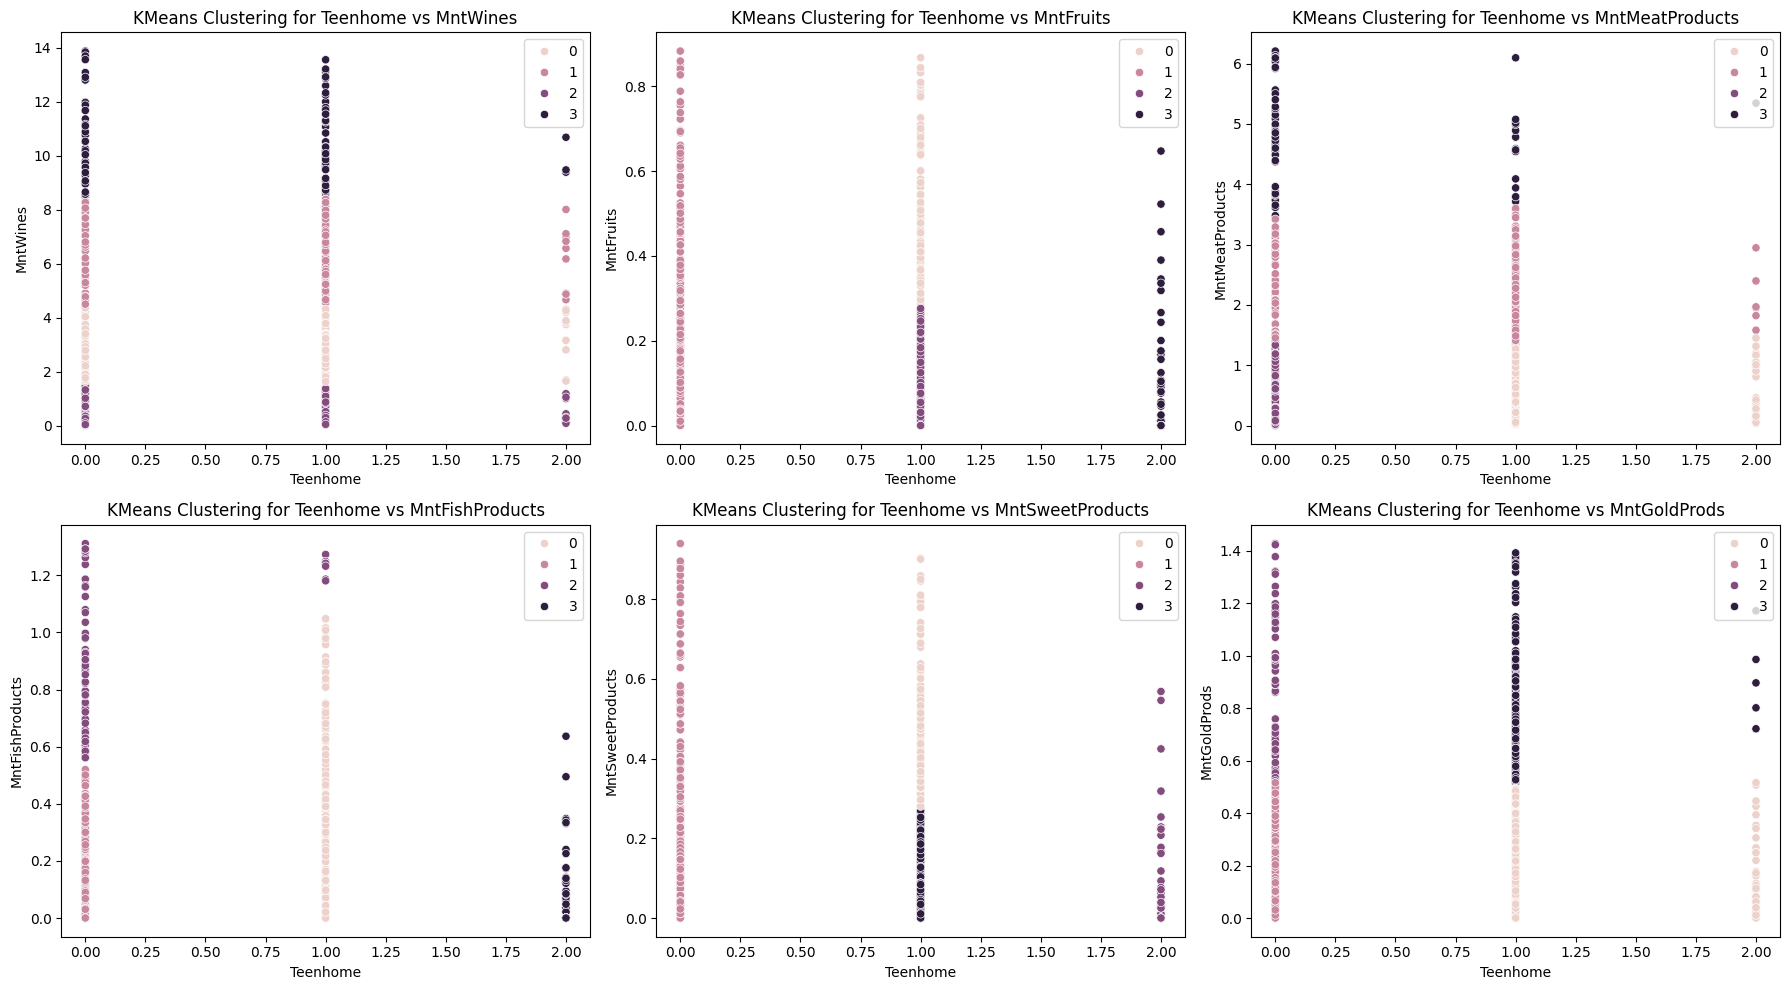

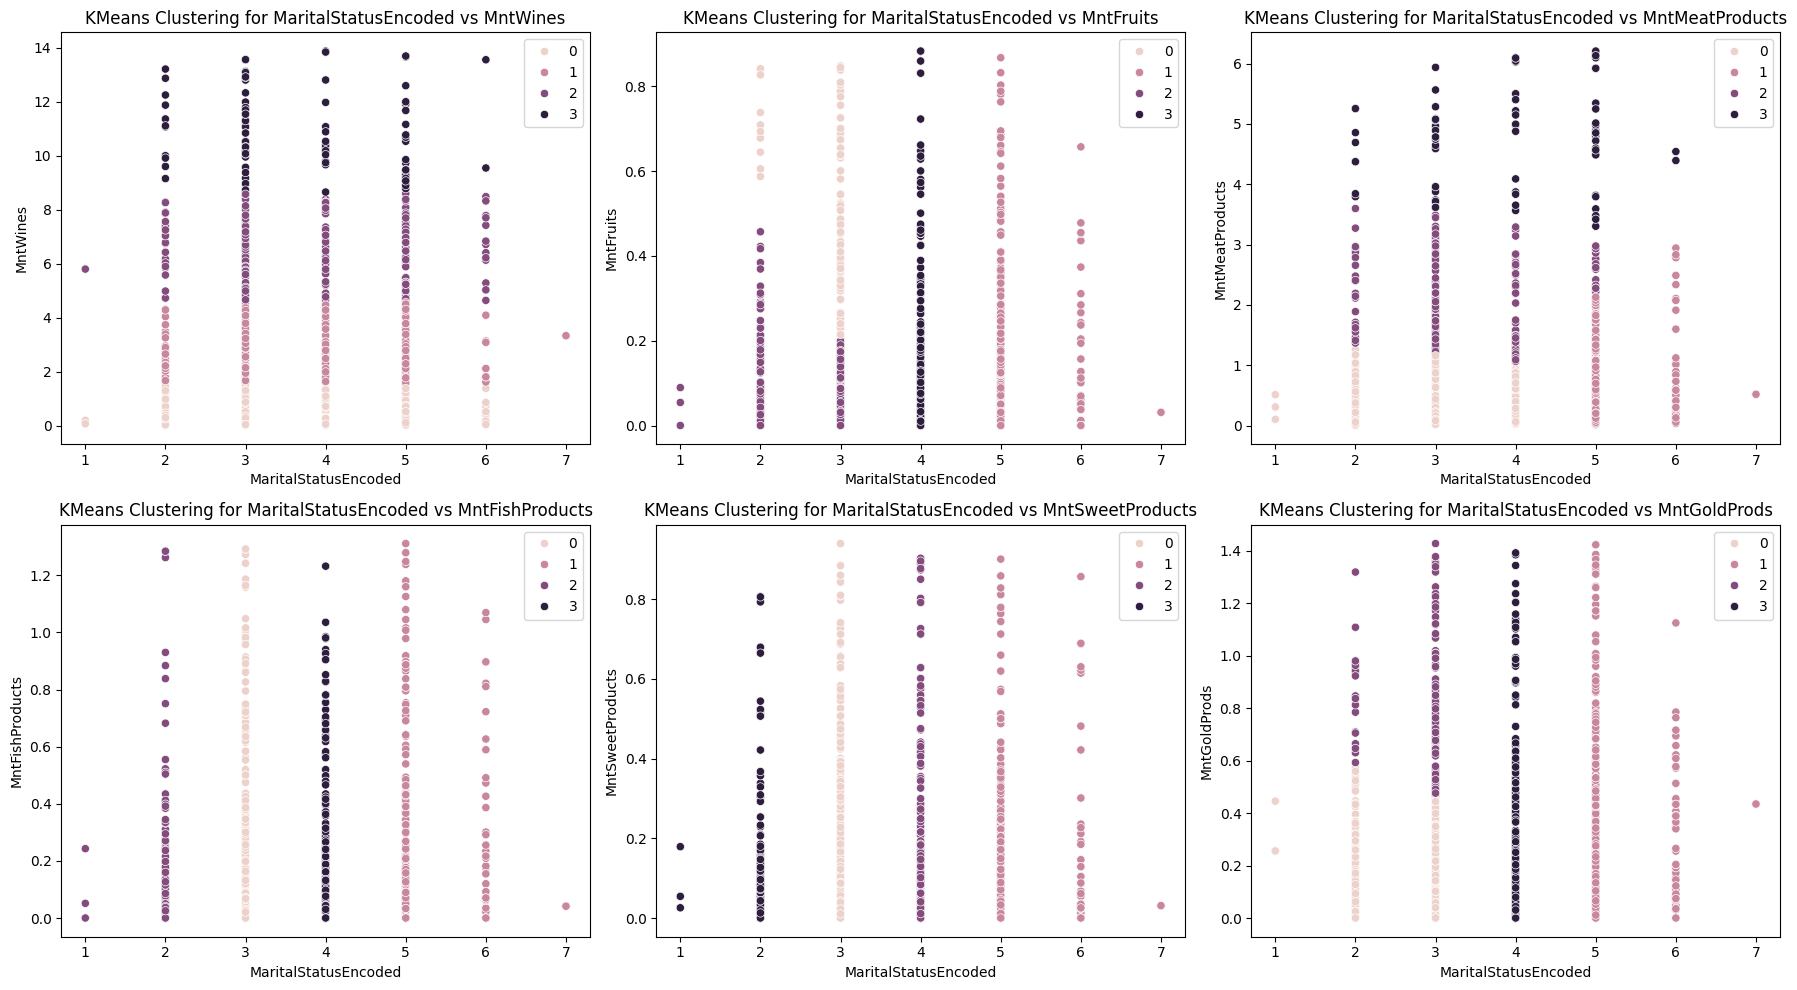

Encoding Mapping for Marital Status:
Absurd: 0
Alone: 1
Divorced: 2
Married: 3
Single: 4
Together: 5
Widow: 6
YOLO: 7


In [242]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Assuming 'customerdf_predictor_cleaned' and 'customerdf_response_cleaned' are lists of column names
for predictor_variable in customerdf_predictor_cleaned:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loop through each response variable
    for i, response_variable in enumerate(customerdf_response_cleaned):
        # Fit KMeans on the specific predictor and response variable
        kmeans.fit(customerdf_joint_cleaned[[predictor_variable, response_variable]])
        
        row = i // 3
        col = i % 3
        sb.scatterplot(data=customerdf_joint_cleaned, x=predictor_variable, y=response_variable, hue=kmeans.labels_, ax=axes[row, col])
        axes[row, col].set_title(f'KMeans Clustering for {predictor_variable} vs {response_variable}')
        axes[row, col].set_xlabel(predictor_variable)
        axes[row, col].set_ylabel(response_variable)

    plt.tight_layout()
    plt.show()

encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Display the mapping
print("Encoding Mapping for Marital Status:")
for label, encoding in encoding_mapping.items():
    print(f"{label}: {encoding}")